This is needed to reload modules without restarting the kernel

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This is needed to add eda_tools from the directories above

In [23]:
import os
os.sys.path.append('../../')

In [24]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep
hep.set_style('ATLAS')

In [25]:
from eda_tools.utilities import getNorm

# Optimization Results analysis

Let's analyse the results of the optimization studies

### Loading data (2016)

In [62]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/data/data_2B_SRshift_16_with_weights.root

-rw-r--r-- 1 lborgna users 527M Apr  8 20:05 /mnt/storage/lborgna/NNT/MDR_VEC/data/data_2B_SRshift_16_with_weights.root


In [27]:
from hh4b_utils.nnt_tools import load_nnt

In [86]:
file_path="/mnt/storage/lborgna/NNT/MDR_VEC/data/data_2B_SRshift_16_with_weights.root"

In [63]:
df = load_nnt(file_path)

In [64]:
df.shape

(1915533, 112)

### Let's define a function to calculate $\chi^2$

In [29]:
def weighted_chisquare(f_obs, f_exp, f_obs_err, f_exp_err, ignore_stats = False, residuals=False, stat_lim = 10):
    #obs = 2b
    #exp = 4b
    
    from scipy.stats import chi2
    
    
    #Calculate weighted chi-square using method in arXiv:physics/0605123
    if ignore_stats == False:
        w1 = f_obs[(f_obs > stat_lim) | (f_exp > stat_lim)]
        w2 = f_exp[(f_obs > stat_lim) | (f_exp > stat_lim)]
        s1 = f_obs_err[(f_obs > stat_lim) | (f_exp > stat_lim)]  # noqa
        s2 = f_exp_err[(f_obs > stat_lim) | (f_exp > stat_lim)]  # noqa
    else:
        w1 = f_obs
        w2 = f_exp
        s1 = f_obs_err # noqa
        s2 = f_exp_err # noqa
    
    ndf = len(w1) - 1
    W1 = np.sum(w1)  # noqa
    W2 = np.sum(w2)  # noqa

    pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))


    R = (W1*w2 - W2*w1)**2 / (W1**2 * s2**2 + W2**2 * s1**2)
    R = np.where(((np.isnan(R)) | (np.isinf(R))), 0, R)
    #X2 = np.sum((W1*w2 - W2*w1)**2 / (W1**2 * s2**2 + W2**2 * s1**2))
    X2 = np.sum(R)
    p_value = chi2.sf(X2, ndf)
    if residuals:
        frac = 1 + ((W2**2)*(s1**2))/((W1**2)/(s2**2))
        top = w1-W1*pi
        bottom = s1 * np.sqrt(1 - 1/frac)
        ri = top/bottom
        return (X2, p_value, ndf, X2/ndf, ri)
    else:
        return (X2, p_value, ndf, X2/ndf)

### Define a function for the shape systematic (might be useful later)

In [186]:
def shape_systematic(
    df: pd.DataFrame,
    feature: str,
    kr: int,
    bins=50,
    hrange=None,
    CR_weights: str = None,
    VR_weights: str = None,
) -> dict:

    mask_2b = df["ntag"] == 2
    mask_kr = df["kinematic_region"] == kr

    if CR_weights is None:
        CR_weights = df.filter(regex="NN_d24_weight_bstrap_med").columns.to_list()[0]

    if VR_weights is None:
        VR_weights = df.filter(
            regex="NN_d24_weight_VRderiv_bstrap_med"
        ).columns.to_list()[0]

    mu_cr = getNorm(df, k=2, weight_column=CR_weights)
    mu_vr = getNorm(df, k=1, weight_column=VR_weights)

    x = df.loc[mask_2b & mask_kr, feature].values
    w_cr = df.loc[mask_2b & mask_kr, CR_weights].values
    w_vr = df.loc[mask_2b & mask_kr, VR_weights].values

    cr_estimate, be = np.histogram(x, bins=bins, range=hrange, weights=mu_cr * w_cr)

    vr_estimate, _ = np.histogram(
        x,
        bins=be,
        range=hrange,
        weights=mu_vr * w_vr,
    )

    inv_estimate, _ = np.histogram(
        x, bins=be, range=hrange, weights=2 * mu_cr * w_cr - mu_vr * w_vr
    )
    results = {}
    results['cr_estimate'] = cr_estimate
    results['vr_estimate'] = vr_estimate
    results['inv_estimate'] = inv_estimate
    results['shape_err'] = np.abs(vr_estimate - cr_estimate)
    results['be'] = be
    
    return results

**ONLY LOOKING AT 2016 FOR NOW**

### Loading weights 

In [40]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_16.h5

-rw-r--r-- 1 lborgna users 1.5G Apr 14 21:56 /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_16.h5


In [41]:
store = pd.HDFStore(
    "/mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_16.h5"
)

In [42]:
df_w = store['df']

In [43]:
df.head(1)

run_number  event_number  pass_vbf_sel  mc_sf  trig_sf  jet_trig_sfs  \
0      298773       1216190         False    1.0      1.0           1.0   

   truth_mhh  ntag  njets  kinematic_region  ...  tagged_vbf_j1  m_vbf_j2  \
0        0.0     2      4                 2  ...          False       0.0   

   E_vbf_j2  pT_vbf_j2  eta_vbf_j2  phi_vbf_j2  tagged_vbf_j2  vbf_mjj  \
0       0.0        0.0         0.0         0.0          False      0.0   

   vbf_dEtajj  vbf_pTvecsum  
0         0.0           0.0  

[1 rows x 89 columns]

In [44]:
models_keys = store.get_storer('df').attrs.model_labels

In [45]:
models_keys

['M1F0T0',
 'M3F0T0',
 'M4F0T0',
 'M5F0T0',
 'M7F0T0',
 'M8F0T0',
 'M9F0T0',
 'M10F0T0',
 'M11F0T0',
 'M20F0T2',
 'M20F1T2',
 'M25F0T0']

In [46]:
store.close()

### Enhance data with weights

In [66]:
df.shape[0] == df_w.shape[0]

True

In [68]:
df = df.merge(
    df_w.drop(columns=["ntag", "kinematic_region", "pass_vbf_sel"]),
    on=["event_number", "run_number"],
    how="inner",
)

In [70]:
df.shape

(1915533, 208)

### Histogram 4b

In [71]:
def histogram_4b(
    df: pd.DataFrame, feature: str, kinematic_region: int, bins=50, hrange: tuple = None
) -> dict:

    mask_kr = df["kinematic_region"] == kinematic_region
    mask_4b = df["ntag"] >= 4

    h_4b, be = np.histogram(
        df.loc[mask_kr & mask_4b, feature].values, bins=bins, range=hrange
    )
    h_4b_err = np.sqrt(h_4b)  # Poisson error (sqrt(N))
    _results = {"h_4b": h_4b, "h_4b_err": h_4b_err, "be_4b": be}
    return _results

In [73]:
be_mhh = np.linspace(250, 1200, 51)

In [99]:
result_4b = histogram_4b(df, 'm_hh', 2, bins =be_mhh)

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7f8b13b42470>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

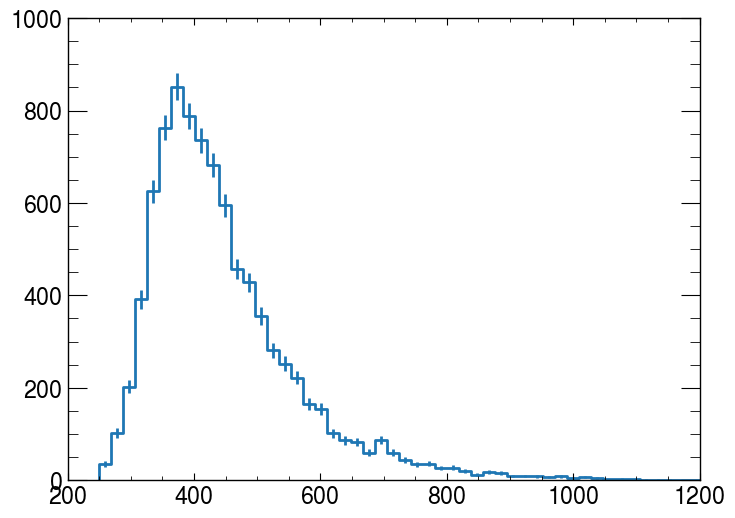

In [75]:
hep.histplot(result['h_4b'], be_mhh, yerr=result['h_4b_err'])

### histogram 2b

In [76]:
def histogram_2b(
    df: pd.DataFrame,
    feature: str,
    kinematic_region: int,
    norm: float,
    weights_column: str=None,
    bins: int = 50,
    hrange: tuple = None,
) -> dict:

    mask_kr = df["kinematic_region"] == kinematic_region
    mask_2b = df["ntag"] == 2

    x = df.loc[mask_kr & mask_2b, feature].values
    if weights_column is not None:
        w = norm * df.loc[mask_kr & mask_2b, weights_column].values
    else:
        w = np.ones(x.shape[0])

    h_2b, be = np.histogram(x, bins=bins, range=hrange, weights=w)
    
    if weights_column is not None:
        # Poisson error of a weighted histogram
        h_2b_err_pois = np.histogram(x, bins=bins, weights=w ** 2)[0]
    else:
        h_2b_err_pois = np.sqrt(h_2b)

    _results = {"h_2b": h_2b, "h_2b_err_pois": h_2b_err_pois, "be_2b": be}
    return _results

In [77]:
df.filter(regex='NN_d24')

NN_d24_weight_bstrap_med_16  NN_d24_weight_bstrap_perc_25_16  \
0                           0.005239                         0.004195   
1                           0.003615                         0.002913   
2                           0.001735                         0.001479   
3                           0.004420                         0.003601   
4                           0.007574                         0.006237   
...                              ...                              ...   
1915528                     0.005495                         0.004623   
1915529                     0.004290                         0.003451   
1915530                     0.001980                         0.001524   
1915531                     0.005176                         0.004235   
1915532                     0.014597                         0.011242   

         NN_d24_weight_bstrap_perc_75_16  NN_d24_weight_bstrap_IQR_16  \
0                               0.006137                     0.001942   
1                               0.004821                     0.001908   
2                               0.002322                     0.000843   
3                               0.005853                     0.002252   
4                               0.009290                     0.003053   
...                                  ...                          ...   
1915528                         0.006488                     0.001865   
1915529                         0.005596                     0.002146   
1915530                         0.002583                     0.001059   
1915531                         0.006821                     0.002586   
1915532                         0.018033                     0.006790   

         NN_d24_weight_VRderiv_bstrap_med_16  \
0                                   0.005843   
1                                   0.002156   
2                                   0.001504   
3                                   0.001886   
4                                   0.005729   
...                                      ...   
1915528                             0.004493   
1915529                             0.003848   
1915530                             0.002521   
1915531                             0.003485   
1915532                             0.006958   

         NN_d24_weight_VRderiv_bstrap_perc_25_16  \
0                                       0.004468   
1                                       0.001559   
2                                       0.001135   
3                                       0.001441   
4                                       0.004746   
...                                          ...   
1915528                                 0.003744   
1915529                                 0.002971   
1915530                                 0.001884   
1915531                                 0.002495   
1915532                                 0.005127   

         NN_d24_weight_VRderiv_bstrap_perc_75_16  \
0                                       0.007102   
1                                       0.002895   
2                                       0.001853   
3                                       0.002352   
4                                       0.007178   
...                                          ...   
1915528                                 0.005158   
1915529                                 0.005490   
1915530                                 0.003378   
1915531                                 0.004387   
1915532                                 0.009039   

         NN_d24_weight_VRderiv_bstrap_IQR_16  \
0                                   0.002634   
1                                   0.001335   
2                                   0.000719   
3                                   0.000911   
4                                   0.002432   
...                                      ...   
1915528                             0.001415   
1915529                             0.002520

In [81]:
norm = getNorm(df, 2, weight_column='NN_d24_weight_bstrap_med_16')

In [82]:
result = histogram_2b(df, 'm_hh', 2, norm, bins=be_mhh, weights_column='NN_d24_weight_bstrap_med_16')

In [83]:
result.keys()

dict_keys(['h_2b', 'h_2b_err_pois', 'be_2b'])

In [84]:
hep.histplot(result['h_2b'], result['be_2b'], yerr=result['h_2b_err_pois'])

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7f8b13e7f828>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

### Bootstrap Error

In [85]:
from eda_tools.bkg_helper import bs_error

In [87]:
from hh4b_utils.nnt_tools import get_mu_iqr

In [91]:
file = uproot.open(file_path)

In [90]:
help(get_mu_iqr)

Help on function get_mu_iqr in module hh4b_utils.nnt_tools:

get_mu_iqr(file, year:int=16, vr:bool=False) -> float
    get nominal iqr of norms value from NNT



In [92]:
mu_iqr = get_mu_iqr(file, 16)

In [94]:
h_2b_bs_err = bs_error(
    df,
    kr = 2,
    be=be_mhh,
    W_med='NN_d24_weight_bstrap_med_16',
    W_IQR='NN_d24_weight_bstrap_IQR_16',
    mu_med = norm,
    mu_IQR = mu_iqr,
    feature = 'm_hh'
)["h_err_bs_mag"]

In [95]:
h_2b_bs_err

array([ 4.21007238,  8.38484181, 15.90410631, 21.98805729, 28.65541107,
       33.68143514, 36.39703953, 36.57178273, 33.38351999, 30.16773414,
       25.50039587, 21.41426158, 17.93732265, 15.52835549, 13.59523755,
       11.13141213,  9.83621796,  8.22690932,  7.43901933,  6.07223874,
        5.3322836 ,  5.21397767,  4.54802721,  3.7947355 ,  3.50371629,
        2.96362698,  2.53019539,  2.27385975,  1.90672088,  1.69839096,
        1.54962252,  1.36053609,  1.13617911,  0.99428596,  0.83754515,
        0.72003955,  0.66208732,  0.57337047,  0.51080386,  0.42397906,
        0.37819083,  0.29168806,  0.23054306,  0.25213532,  0.16635116,
        0.14595565,  0.12677791,  0.10092003,  0.10908649,  0.1107239 ])

In [96]:
total_error = np.sqrt(h_2b_bs_err**2 + result['h_2b_err_pois']**2)

In [98]:
hep.histplot(result['h_2b'], result['be_2b'], yerr=total_error)
hep.histplot(result['h_2b'], result['be_2b'], yerr=result['h_2b_err_pois'])

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7f8af0509ef0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

In [100]:
weighted_chisquare(
    result["h_2b"], result_4b["h_4b"], total_error, result_4b["h_4b_err"]
)

(42.00747172457894, 0.13526116461819046, 33, 1.2729536886236044)

In [101]:
weighted_chisquare(
    result["h_2b"], result_4b["h_4b"], result['h_2b_err_pois'], result_4b["h_4b_err"]
)

(56.61633601017144, 0.006438850554659644, 33, 1.7156465457627708)

# Calculating $\chi^2$ and $W(\mu, \nu)$ with multiple features 

In [102]:
features = ["m_hh", "X_wt_tag", "pt_hh", "dEta_hh"]
ranges = [(200, 1200), (1.5, 9), (0, 250), (0, 1.5)]
nbins = [50, 50, 50, 50]


In [115]:
bin_edges = []
for hrange, nb in zip(ranges, nbins):
    be = np.linspace(hrange[0], hrange[1], nb+1)
    bin_edges.append(be)

In [124]:
help(histogram_2b)

Help on function histogram_2b in module __main__:

histogram_2b(df:pandas.core.frame.DataFrame, feature:str, kinematic_region:int, norm:float, weights_column:str=None, bins:int=50, hrange:tuple=None) -> dict



In [125]:
from scipy.stats import wasserstein_distance

In [133]:
np.sum(nbins)

200

In [136]:
emds = np.zeros(len(features))
chis2 = np.zeros(len(features))
histos_2b = np.array([])
error_2b = np.array([])
histos_4b = np.array([])
error_4b = np.array([])
for i, (feature, be) in enumerate(zip(features, bin_edges)):

    r4b = histogram_4b(df, feature=feature, kinematic_region=2, bins=be)
    histos_4b = np.append(histos_4b, r4b['h_4b'])
    error_4b = np.append(error_4b, r4b['h_4b_err'])

    r2b = histogram_2b(
        df,
        feature=feature,
        kinematic_region=2,
        norm=norm,
        weights_column="NN_d24_weight_bstrap_med_16",
        bins=be,
    )
    histos_2b = np.append(histos_2b, r2b['h_2b'])
    error_2b = np.append(error_2b, r2b['h_2b_err_pois'])
    
    emd = wasserstein_distance(r4b['h_4b'], r2b['h_2b'])
    emds[i] = emd
    chi2 = weighted_chisquare(r2b['h_2b'], r4b['h_4b'], r2b['h_2b_err_pois'], r4b['h_4b_err'])[-1]
    chis2[i] = chi2

In [137]:
weighted_chisquare(histos_2b, histos_4b, error_2b, error_4b)[-1]

1.363875983515524

In [141]:
np.median(chis2)

1.3032050736857865

In [131]:
emds

array([ 6.95734437, 10.79581887,  9.53536231,  7.40162633])

**Generate all of the desired histograms**

In [ ]:
def generate_histograms(
    df: pd.DataFrame,
    features: list,
    bin_edges: list,
    norm: float,
    kinematic_region: int,
    weights_column: str,
) -> dict:

    histos_2b = np.array([])
    histos_4b = np.array([])
    error_2b = np.array([])
    error_4b = np.array([])
    emds = np.array([])
    for i, (feature, be) in enumerate(zip(features, bin_edges)):

        r4b = histogram_4b(
            df, feature=feature, kinematic_region=kinematic_region, bins=be
        )
        histos_4b = np.append(histos_4b, r4b["h_4b"])
        error_4b = np.append(error_4b, r4b["h_4b_err"])

        r2b = histogram_2b(
            df,
            feature=feature,
            kinematic_region=kinematic_region,
            norm=norm,
            weights_column=weights_column,
            bins=be,
        )
        histos_2b = np.append(histos_2b, r2b["h_2b"])
        error_2b = np.append(error_2b, r2b["h_2b_err_pois"])

        emd = wasserstein_distance(r4b["h_4b"], r2b["h_2b"])
        emds = np.append(emds, emd)
    return {
        "histos_2b": histos_2b,
        "histos_2b_poi_err": error_2b,
        "histos_4b": histos_4b,
        "histos_4b_poi_err": error_4b,
        "emds": emds,
    }

In [156]:
histos = generate_histograms(df, features, bin_edges, norm, kinematic_region=2, weights_column='NN_d24_weight_bstrap_med_16')

In [152]:
weighted_chisquare(histos['histos_2b'], histos['histos_4b'], histos['histos_2b_poi_err'], histos['histos_4b_poi_err'])

(235.95054514818565, 0.0010404199860405232, 173, 1.363875983515524)

In [170]:
wasserstein_distance(histos['histos_4b'][0:len(bin_edges[0])-1], histos['histos_2b'][0:len(bin_edges[0])-1])

6.957344367476467

In [172]:
i = 0
for be in bin_edges:

    print(
        wasserstein_distance(
            histos["histos_2b"][i : i + len(be) - 1],
            histos["histos_4b"][i : i + len(be) - 1],
        )
    )
    i = i + len(be) - 1

6.957344367476467
10.795818872624261
9.535362314176336
7.401626329140237


In [174]:
help(bs_error)

Help on function bs_error in module eda_tools.bkg_helper:

bs_error(df, kr, be, W_med, W_IQR, mu_med, mu_IQR, feature='m_hh_cor', hrange=(200, 1600))



**Generate all of the desired bootstrap errors**

In [178]:
def generate_bootstrap_errors(
    df: pd.DataFrame,
    features: list,
    bin_edges: list,
    kinematic_region: int,
    norm: float,
    norm_iqr: float,
    weights_column: str,
    weights_iqr: str,
) -> dict:

    bs_error_2b = np.array([])

    for i, (feature, be) in enumerate(zip(features, bin_edges)):
        bs_err = bs_error(
            df,
            kr=kinematic_region,
            be=be,
            mu_med=norm,
            mu_IQR=norm_iqr,
            W_med=weights_column,
            W_IQR=weights_iqr,
            feature=feature,
        )["h_err_bs_mag"]
        bs_error_2b = np.append(bs_error_2b, bs_err)

    return {"bs_err": bs_error_2b}

In [179]:
bs_err = generate_bootstrap_errors(
    df,
    features,
    bin_edges,
    kinematic_region=2,
    norm=norm,
    norm_iqr=mu_iqr,
    weights_column="NN_d24_weight_bstrap_med_16",
    weights_iqr= "NN_d24_weight_bstrap_IQR_16"
)

In [181]:
weighted_chisquare(
    histos["histos_2b"],
    histos["histos_4b"],
    np.sqrt(histos["histos_2b_poi_err"] ** 2 + bs_err["bs_err"] ** 2),
    histos["histos_4b_poi_err"],
)

(179.79177007503253, 0.34598220219883624, 173, 1.0392587865608818)

**Generate all of the desired shape systematic**

In [192]:
def generate_shape_systematic(
    df: pd.DataFrame,
    features: list,
    bin_edges: list,
    kinematic_region: int,
    weights_CR_column: str,
    weights_VR_column: str,
) -> dict:

    shape_syst_2b = np.array([])

    for i, (feature, be) in enumerate(zip(features, bin_edges)):
        shape_err = shape_systematic(
            df,
            feature = feature,
            kr = kinematic_region,
            bins = be,
            CR_weights= weights_CR_column,
            VR_weights= weights_VR_column
        )['shape_err']
        shape_syst_2b = np.append(shape_syst_2b, shape_err)
    return {"shape_err": shape_syst_2b}

In [193]:
shape_err = generate_shape_systematic(
    df, features, bin_edges, kinematic_region=2,
    weights_CR_column='NN_d24_weight_bstrap_med_16',
    weights_VR_column='NN_d24_weight_VRderiv_bstrap_med_16'
)

In [194]:
shape_err

{'shape_err': array([2.69379737e-02, 3.76984675e-02, 3.57111396e+00, 1.11970073e+01,
        2.64728595e+01, 5.23755939e+01, 7.32962169e+01, 9.53920153e+01,
        1.06513651e+02, 1.16808632e+02, 1.25013616e+02, 1.22814581e+02,
        1.08444706e+02, 9.58232002e+01, 8.39553183e+01, 7.43039812e+01,
        6.30838385e+01, 5.10954250e+01, 4.54961688e+01, 3.82790519e+01,
        3.17307973e+01, 2.71821658e+01, 2.36170223e+01, 2.12525524e+01,
        1.76013802e+01, 1.43725113e+01, 1.26969452e+01, 1.08886691e+01,
        9.21892098e+00, 7.48112707e+00, 5.78302695e+00, 5.75600917e+00,
        4.35487293e+00, 3.75927309e+00, 2.57794854e+00, 1.82369709e+00,
        2.19520330e+00, 1.29246616e+00, 1.17674682e+00, 1.12875478e+00,
        9.52442993e-01, 4.88426137e-01, 5.64775060e-01, 4.86853208e-01,
        3.78254326e-01, 2.39894265e-01, 1.87673697e-01, 9.71449088e-02,
        4.69146787e-02, 9.00234793e-02, 8.72380235e+01, 8.63390861e+01,
        8.54582447e+01, 8.36631236e+01, 8.04169438e

# Calculate all the closure and extrapolations CRs

There's 4 different cases

- closure: CR region x CR Model (kr = 2, 'NN_d24_weight_bstrap_med')
- closure: VR region x VR Model (kr = 1, 'NN_d24_weight_VRderiv_bstrap_med')
- extrapolation: VR region x CR model (kr = 1, 'NN_d24_weight_bstrap_med')
- extrapolation: CR region x VR model (kr = 2, 'NN_d24_weight_VRderiv_bstrap_med')


**These functions will be useful later**

In [210]:
def w_col(year: int, vr: bool = False, weight_label: str = None) -> str:
    """returns the nominal weight column name"""
    vr_prefix = "_VRderiv" if vr else ""
    weight_prefix = f"_{weight_label}" if weight_label is not None else ""
    return f"NN_d24_weight{vr_prefix}{weight_prefix}_bstrap_med_{year}"

def w_iqr(year: int, vr: bool = False, weight_label: str = None) -> str:
    """returns the nominal weights iqr column name"""
    vr_prefix = "_VRderiv" if vr else ""
    weight_prefix = f"_{weight_label}" if weight_label is not None else ""
    return f"NN_d24_weight{vr_prefix}{weight_prefix}_bstrap_IQR_{year}"

In [213]:
def get_mu_iqr(file, year: int = 16, vr: bool = False) -> float:
    """get nominal iqr of norms value from NNT"""
    vr_fix = "_VRderiv" if vr else ""
    return file[f"NN_norm{vr_fix}_bstrap_IQR_{year}"]._fVal

In [224]:
labels = ["CRxCR", "VRxVR", "VRxCR", "CRxVR"]
krs = [2, 1, 1, 2]
model_region = ["CR", "VR", "CR", "VR"]
features = ["m_hh", "X_wt_tag", "pt_hh", "dEta_hh"]
ranges = [(200, 1200), (1.5, 9), (0, 250), (0, 1.5)]
nbins = [50, 50, 50, 50]
bin_edges = []
for hrange, nb in zip(ranges, nbins):
    be = np.linspace(hrange[0], hrange[1], nb + 1)
    bin_edges.append(be)

chis2 = np.zeros(len(labels))
chis2_bs = np.zeros(len(labels))
chis2_shape = np.zeros(len(labels))
emds = np.zeros(len(labels))
for i, (l, kr, model_kr) in enumerate(zip(labels, krs, model_region)):
    print(l)

    weight_cr_col = w_col(16)
    weight_cr_iqr_col = w_iqr(16)
    weight_vr_col = w_col(16, vr=True)
    weight_vr_iqr_col = w_iqr(16, vr=True)

    if model_kr == "CR":
        weight_column = weight_cr_col
        weights_iqr_col = weight_cr_iqr_col
        mu_iqr = get_mu_iqr(file, 16)
        norm = getNorm(df, k=2, weight_column=weight_column)
    elif model_kr == "VR":
        weight_column = weight_vr_col
        weights_iqr_col = weight_vr_iqr_col
        mu_iqr = get_mu_iqr(file, 16, vr=True)
        norm = getNorm(df, k=1, weight_column=weight_column)

    histos = generate_histograms(
        df,
        features,
        bin_edges,
        norm,
        kinematic_region=kr,
        weights_column=weight_column,
    )
    print("generated histos")
    bs_err = generate_bootstrap_errors(
        df,
        features,
        bin_edges,
        kinematic_region=kr,
        norm=norm,
        norm_iqr=mu_iqr,
        weights_column=weight_column,
        weights_iqr=weights_iqr_col,
    )
    print("generated bs_error")
    shape_err = generate_shape_systematic(
        df,
        features,
        bin_edges,
        kinematic_region=kr,
        weights_CR_column=weight_cr_col,
        weights_VR_column=weight_vr_col,
    )
    print("generated shape error")

    chi = weighted_chisquare(
        histos["histos_2b"],
        histos["histos_4b"],
        histos["histos_2b_poi_err"],
        histos["histos_4b_poi_err"],
    )[-1]
    
    chi_bs = weighted_chisquare(
        histos["histos_2b"],
        histos["histos_4b"],
        np.sqrt(histos["histos_2b_poi_err"]**2 + bs_err['bs_err']**2),
        histos["histos_4b_poi_err"],
    )[-1]
    
    chi_shape = weighted_chisquare(
        histos["histos_2b"],
        histos["histos_4b"],
        np.sqrt(shape_err['shape_err']**2 + histos["histos_2b_poi_err"]**2 + bs_err['bs_err']**2),
        histos["histos_4b_poi_err"],
    )[-1]
    
    emd_mean = histos["emds"].mean()
    emds = np.append(emds, emd_mean)
    
    chis2 = np.append(chis2, chi)
    chis2_bs = np.append(chis2_bs, chi_bs)
    chis2_shape = np.append(chis2_shape, chi_shape)

CRxCR
generated histos
generated bs_error
generated shape error
VRxVR
generated histos
generated bs_error
generated shape error
VRxCR
generated histos
generated bs_error
generated shape error
CRxVR
generated histos
generated bs_error
generated shape error


In [219]:
from scipy.spatial.distance import euclidean

In [223]:
euclidean(chis2, np.ones(len(chis2)))

2.34605692919269

In [225]:
euclidean(chis2_bs, np.ones(len(chis2_bs)))

2.088890492663369

In [226]:
euclidean(chis2_shape, np.ones(len(chis2_shape)))

2.317394126542683

In [258]:
file.keys()

[b'sig;1',
 b'validation;1',
 b'control;1',
 b'NN_norm_bstrap_med_16;1',
 b'NN_norm_bstrap_IQR_16;1',
 b'NN_norm_bstrap_perc_25_16;1',
 b'NN_norm_bstrap_perc_75_16;1',
 b'NN_norm_VRderiv_bstrap_med_16;1',
 b'NN_norm_VRderiv_bstrap_IQR_16;1',
 b'NN_norm_VRderiv_bstrap_perc_25_16;1',
 b'NN_norm_VRderiv_bstrap_perc_75_16;1']

In [259]:
df['ntag'][0]

2

In [275]:
def get_norm(df:pd.DataFrame, year:int=16, vr=False, weight_label:str=None)->float:
    vr_prefix = "_VRderiv" if vr else ""
    weight_prefix = f"_{weight_label}" if weight_label is not None else ""
    column = f'NN_norm{vr_prefix}{weight_prefix}_bstrap_med_{year}'
    norm = df[column][0]
    return norm
    

In [270]:
df.filter(regex='IQR')

NN_d24_weight_bstrap_IQR_16  NN_d24_weight_VRderiv_bstrap_IQR_16  \
0                           0.001942                             0.002634   
1                           0.001908                             0.001335   
2                           0.000843                             0.000719   
3                           0.002252                             0.000911   
4                           0.003053                             0.002432   
...                              ...                                  ...   
1915528                     0.001865                             0.001415   
1915529                     0.002146                             0.002520   
1915530                     0.001059                             0.001494   
1915531                     0.002586                             0.001892   
1915532                     0.006790                             0.003912   

         NN_d24_weight_M1F0T0_bstrap_IQR_16  NN_norm_M1F0T0_bstrap_IQR_16  \
0                                  0.003076                      0.033744   
1                                  0.001001                      0.033744   
2                                  0.000454                      0.033744   
3                                  0.002522                      0.033744   
4                                  0.001430                      0.033744   
...                                     ...                           ...   
1915528                            0.001518                      0.033744   
1915529                            0.002739                      0.033744   
1915530                            0.001418                      0.033744   
1915531                            0.001974                      0.033744   
1915532                            0.006853                      0.033744   

         NN_d24_weight_VRderiv_M1F0T0_bstrap_IQR_16  \
0                                          0.001252   
1                                          0.001206   
2                                          0.000533   
3                                          0.000998   
4                                          0.001969   
...                                             ...   
1915528                                    0.001131   
1915529                                    0.001179   
1915530                                    0.001739   
1915531                                    0.002164   
1915532                                    0.005928   

         NN_norm_VRderiv_M1F0T0_bstrap_IQR_16  \
0                                    0.027357   
1                                    0.027357   
2                                    0.027357   
3                                    0.027357   
4                                    0.027357   
...                                       ...   
1915528                              0.027357   
1915529                              0.027357   
1915530                              0.027357   
1915531                              0.027357   
1915532                              0.027357   

         NN_d24_weight_M3F0T0_bstrap_IQR_16  NN_norm_M3F0T0_bstrap_IQR_16  \
0                                  0.002674                       0.11944   
1                                  0.003385                       0.11944   
2                                  0.000570                       0.11944   
3                                  0.002374                       0.11944   
4                                  0.000913                       0.11944   
...                                     ...                           ...   
1915528                            0.001297                       0.11944   
1915529                            0.001574                       0.11944   
1915530                            0.001548                       0.11944   
1915531                            0.001712                       0.11944   
1915532                            0.004833                   

In [269]:
get_norm(df, 16, vr=False,weight_label='M1F0T0')

1.0512279551726667

In [276]:
def get_norm_iqr(df:pd.DataFrame, year:int=16, vr=False, weight_label:str=None)->float:
    vr_prefix = "_VRderiv" if vr else ""
    weight_prefix = f"_{weight_label}" if weight_label is not None else ""
    column = f'NN_norm{vr_prefix}{weight_prefix}_bstrap_IQR_{year}'
    norm = df[column][0]
    return norm
    

In [273]:
get_norm_iqr(df, 16, vr=True, weight_label='M1F0T0')

0.02735696313371694

In [333]:
def analyze_reweighting(
    df: pd.DataFrame,
    features: list,
    bin_edges: list,
    model_label: str = None,
    year: int = 16,
    verbose: bool = False,
) -> dict:

    labels = ["CRxCR", "VRxVR", "VRxCR", "CRxVR"]
    krs = [2, 1, 1, 2]
    model_region = ["CR", "VR", "CR", "VR"]

    chis2 = np.zeros(len(labels))
    chis2_bs = np.zeros(len(labels))
    chis2_shape = np.zeros(len(labels))
    emds = np.zeros(len(labels))

    h2b_all = np.array([])
    h4b_all = np.array([])
    error_2b_poi_all = np.array([])
    error_2b_bs_all = np.array([])
    error_2b_shape_all = np.array([])
    error_4b_poi_all = np.array([])

    for i, (l, kr, model_kr) in enumerate(zip(labels, krs, model_region)):
        if verbose:
            print(l)

        weight_cr_col = w_col(year, weight_label=model_label)
        weight_cr_iqr_col = w_iqr(year, weight_label=model_label)
        weight_vr_col = w_col(year, vr=True, weight_label=model_label)
        weight_vr_iqr_col = w_iqr(year, vr=True, weight_label=model_label)

        if model_kr == "CR":
            weight_column = weight_cr_col
            weights_iqr_col = weight_cr_iqr_col
            norm = get_norm(df, year, weight_label=model_label)
            mu_iqr = get_norm_iqr(df, year, weight_label=model_label)
            # norm = getNorm(df, k=2, weight_column=weight_column)
        elif model_kr == "VR":
            weight_column = weight_vr_col
            weights_iqr_col = weight_vr_iqr_col
            norm = get_norm(df, year, vr=True, weight_label=model_label)
            mu_iqr = get_norm_iqr(df, year=year, vr=True, weight_label=model_label)
            # norm = getNorm(df, k=1, weight_column=weight_column)

        histos = generate_histograms(
            df,
            features,
            bin_edges,
            norm,
            kinematic_region=kr,
            weights_column=weight_column,
        )
        if verbose:
            print("generated histos")
        bs_err = generate_bootstrap_errors(
            df,
            features,
            bin_edges,
            kinematic_region=kr,
            norm=norm,
            norm_iqr=mu_iqr,
            weights_column=weight_column,
            weights_iqr=weights_iqr_col,
        )
        if verbose:
            print("generated bs_error")
        shape_err = generate_shape_systematic(
            df,
            features,
            bin_edges,
            kinematic_region=kr,
            weights_CR_column=weight_cr_col,
            weights_VR_column=weight_vr_col,
        )
        if verbose:
            print("generated shape error")

        chi = weighted_chisquare(
            histos["histos_2b"],
            histos["histos_4b"],
            histos["histos_2b_poi_err"],
            histos["histos_4b_poi_err"],
        )[-1]

        chi_bs = weighted_chisquare(
            histos["histos_2b"],
            histos["histos_4b"],
            np.sqrt(histos["histos_2b_poi_err"] ** 2 + bs_err["bs_err"] ** 2),
            histos["histos_4b_poi_err"],
        )[-1]

        chi_shape = weighted_chisquare(
            histos["histos_2b"],
            histos["histos_4b"],
            np.sqrt(
                shape_err["shape_err"] ** 2
                + histos["histos_2b_poi_err"] ** 2
                + bs_err["bs_err"] ** 2
            ),
            histos["histos_4b_poi_err"],
        )[-1]

        h2b_all = np.append(h2b_all, histos["histos_2b"])
        h4b_all = np.append(h4b_all, histos["histos_4b"])
        error_2b_poi_all = np.append(error_2b_poi_all, histos["histos_2b_poi_err"])
        error_2b_bs_all = np.append(error_2b_bs_all, bs_err["bs_err"])
        error_2b_shape_all = np.append(error_2b_shape_all, shape_err["shape_err"])
        error_4b_poi_all = np.append(error_4b_poi_all, histos["histos_4b_poi_err"])

        emd_mean = histos["emds"].mean()
        emds = np.append(emds, emd_mean)

        chis2 = np.append(chis2, chi)
        chis2_bs = np.append(chis2_bs, chi_bs)
        chis2_shape = np.append(chis2_shape, chi_shape)

    ed = euclidean(chis2, np.ones(len(chis2)))
    ed_bs = euclidean(chis2_bs, np.ones(len(chis2_bs)))
    ed_shape = euclidean(chis2_shape, np.ones(len(chis2_shape)))
    ed_emd = euclidean(emds, np.zeros(len(emds)))

    chi2_all = weighted_chisquare(h2b_all, h4b_all, error_2b_poi_all, error_4b_poi_all)[
        -1
    ]
    chi2_bs_all = weighted_chisquare(
        h2b_all,
        h4b_all,
        np.sqrt(error_2b_bs_all ** 2 + error_2b_poi_all ** 2),
        error_4b_poi_all,
    )[-1]
    chi2_shape_all = weighted_chisquare(
        h2b_all,
        h4b_all,
        np.sqrt(error_2b_poi_all ** 2 + error_2b_bs_all ** 2 + error_2b_shape_all ** 2),
        error_4b_poi_all,
    )[-1]

    results = {
        "chis2": chis2,
        "chis2_bs": chis2_bs,
        "chis2_shape": chis2_shape,
        "emds": emds,
        "ed": ed,
        "ed_bs": ed_bs,
        "ed_shape": ed_shape,
        "ed_emd": ed_emd,
        "chi2_all": chi2_all,
        "chi2_bs_all": chi2_bs_all,
        "chi2_shape_all": chi2_shape_all
    }
    return results

# Calculate it for the different models

In [227]:
models_keys

['M1F0T0',
 'M3F0T0',
 'M4F0T0',
 'M5F0T0',
 'M7F0T0',
 'M8F0T0',
 'M9F0T0',
 'M10F0T0',
 'M11F0T0',
 'M20F0T2',
 'M20F1T2',
 'M25F0T0']

In [257]:
help(analyze_reweighting)

Help on function analyze_reweighting in module __main__:

analyze_reweighting(df, features, bin_edges, model_label) -> dict



In [280]:
models_keys

['M1F0T0',
 'M3F0T0',
 'M4F0T0',
 'M5F0T0',
 'M7F0T0',
 'M8F0T0',
 'M9F0T0',
 'M10F0T0',
 'M11F0T0',
 'M20F0T2',
 'M20F1T2',
 'M25F0T0']

In [335]:
chis = {}
chis_bs = {}
chis_shape = {}
ed = {}
ed_bs = {}
ed_shape = {}
ed_emd = {}
chis2_all = {}
chis2_bs_all = {}
chis2_shape_all = {}

for model in models_keys:
    print(model)
    model_results = analyze_reweighting(df, features, bin_edges, model, verbose= False)
    chis[model] = model_results['chis2']
    chis_bs[model] = model_results['chis2_bs']
    chis_shape[model] = model_results['chis2_shape']
    ed[model] = model_results['ed']
    ed_bs[model] = model_results['ed_bs']
    ed_shape[model] = model_results['ed_shape']
    ed_emd[model] = model_results['ed_emd']
    chis2_all[model] = model_results['chi2_all']
    chis2_bs_all[model] = model_results['chi2_bs_all']
    chis2_shape_all[model] = model_results['chi2_shape_all']
    

M1F0T0
M3F0T0
M4F0T0
M5F0T0
M7F0T0
M8F0T0
M9F0T0
M10F0T0
M11F0T0
M20F0T2
M20F1T2
M25F0T0


In [291]:
ed.keys

<function dict.keys>

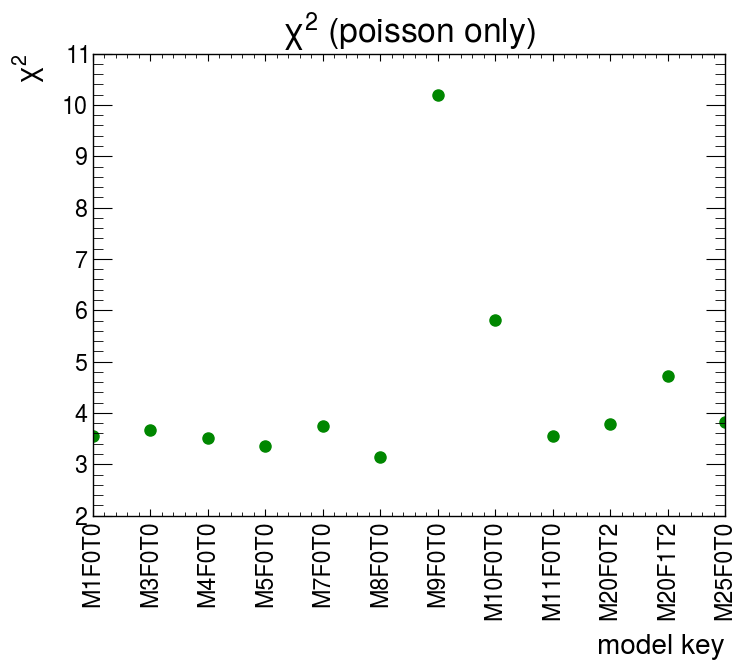

In [342]:
plt.plot(chis2_all.keys(), chis2_all.values(), 'o')
plt.title(r'$\chi^2$ (poisson only)')
plt.ylabel(r'$\chi^2$')
plt.xlabel('model key')
_=plt.xticks(rotation=90)

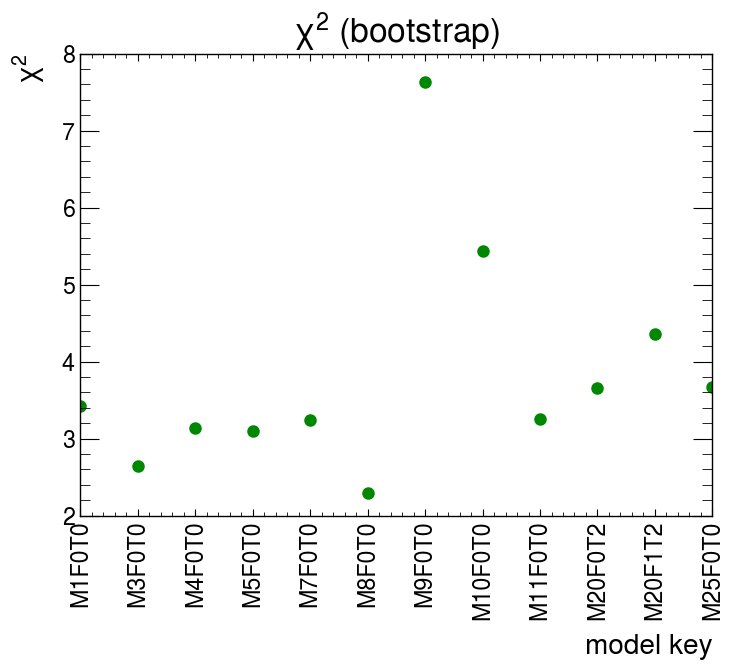

In [343]:
plt.plot(chis2_bs_all.keys(), chis2_bs_all.values(), 'o')
plt.title(r'$\chi^2$ (bootstrap)')
plt.ylabel(r'$\chi^2$')
plt.xlabel('model key')
_=plt.xticks(rotation=90)

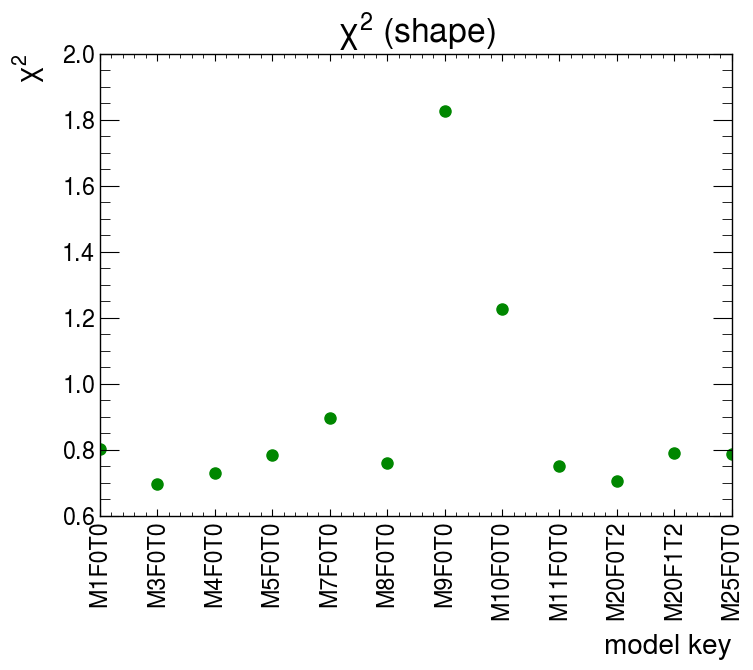

In [339]:
plt.plot(chis2_shape_all.keys(), chis2_shape_all.values(), 'o')
plt.title(r'$\chi^2$ (shape)')
plt.ylabel(r'$\chi^2$')
plt.xlabel('model key')
_ = plt.xticks(rotation=90)

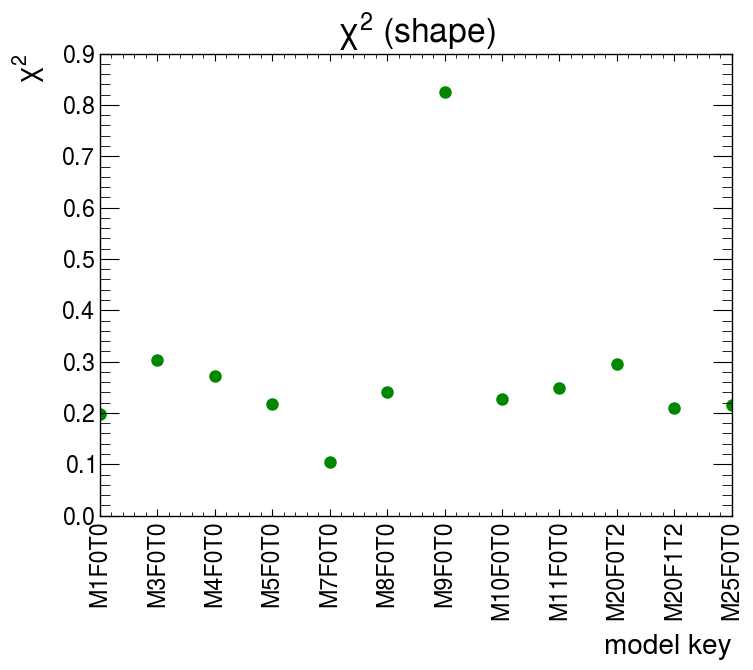

In [341]:
ed_chis2_all = []
for chi2s in chis2_shape_all.values():
    ed_chis2_all.append(euclidean(chi2s, 1))
plt.plot(chis2_shape_all.keys(), ed_chis2_all, 'o')
plt.title(r'$\chi^2$ (shape)')
plt.ylabel(r'$\chi^2$')
plt.xlabel('model key')
_ = plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

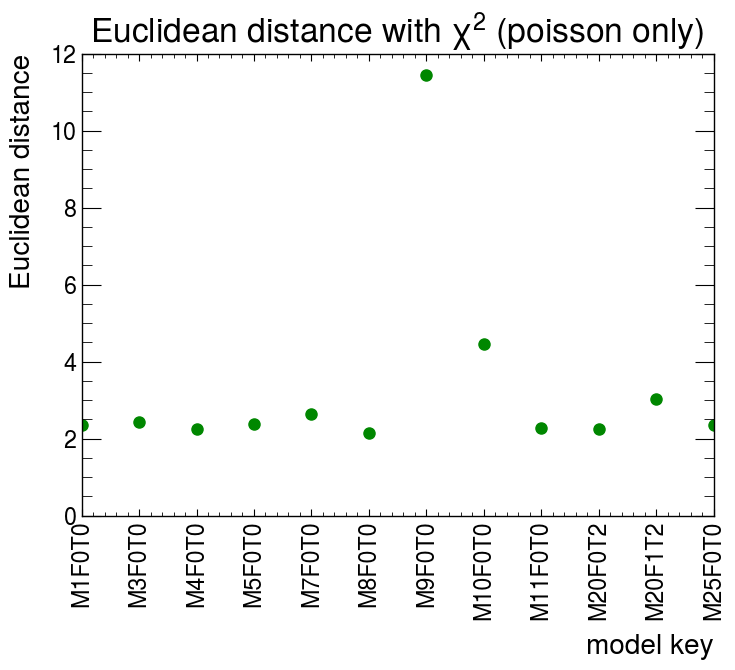

In [314]:
plt.plot(ed.keys(), ed.values(), 'o')
plt.title('Euclidean distance with $\chi^2$ (poisson only)')
plt.ylabel('Euclidean distance')
plt.xlabel('model key')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

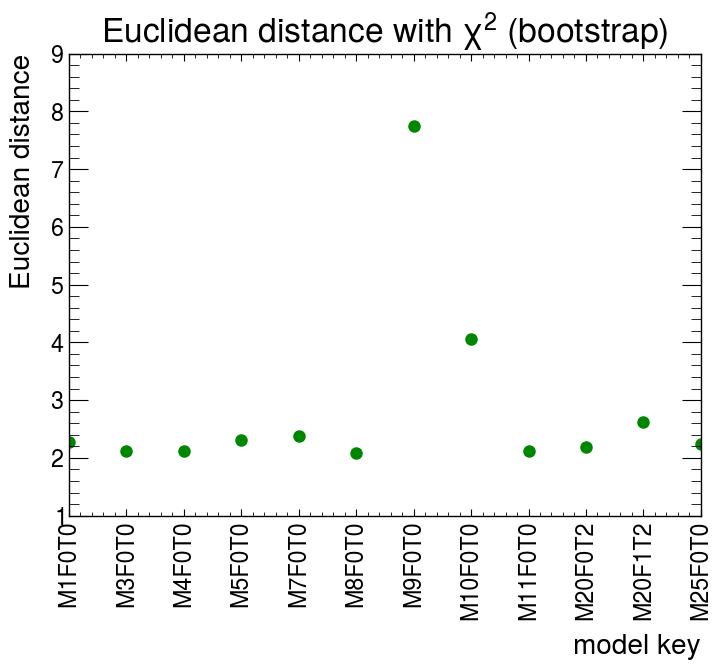

In [315]:
plt.plot(ed_bs.keys(), ed_bs.values(), 'o')
plt.title('Euclidean distance with $\chi^2$ (bootstrap)')
plt.ylabel('Euclidean distance')
plt.xlabel('model key')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

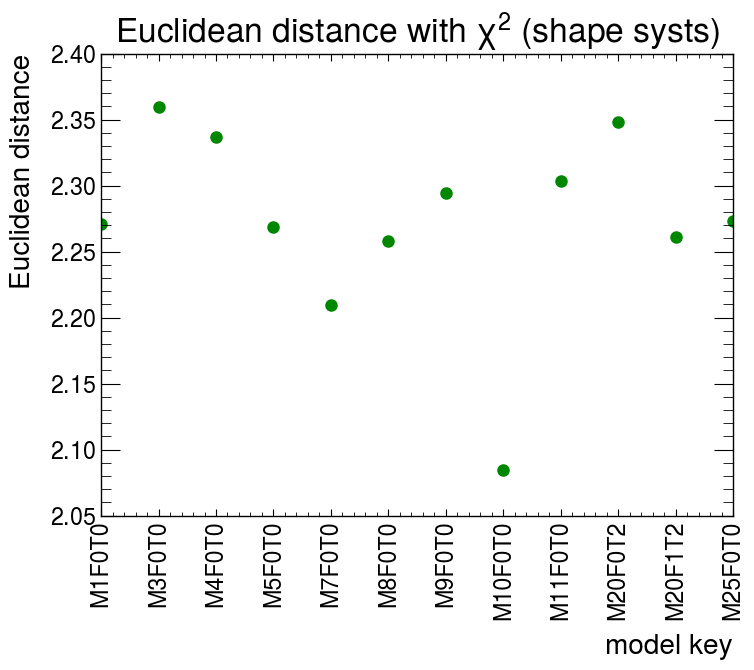

In [316]:
plt.plot(ed_shape.keys(), ed_shape.values(), 'o')
plt.title('Euclidean distance with $\chi^2$ (shape systs)')
plt.ylabel('Euclidean distance')
plt.xlabel('model key')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

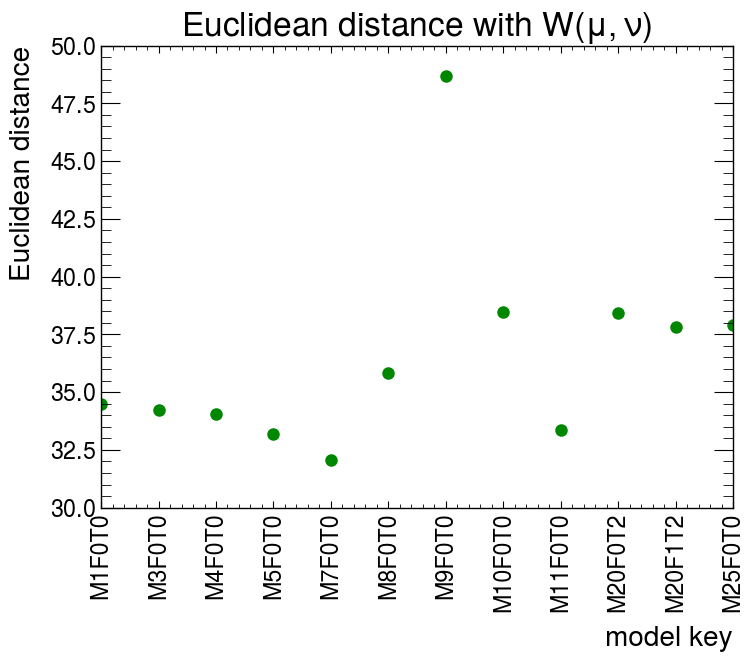

In [317]:
plt.plot(ed_emd.keys(), ed_emd.values(), 'o')
plt.title(r'Euclidean distance with $W(\mu, \nu)$')
plt.ylabel('Euclidean distance')
plt.xlabel('model key')
plt.xticks(rotation=90)

In [ ]:
y = [2.56422, 3.77284, 3.52623, 3.51468, 3.02199]
z = [0.15, 0.3, 0.45, 0.6, 0.75]
n = [58, 651, 393, 203, 123]

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

In [309]:
x

array(dict_values([2.341149601732385, 2.433781471235553, 2.242392325144453, 2.390384618874988, 2.6338109991856675, 2.143879079072039, 11.45117767715235, 4.448114948240724, 2.2708912883479573, 2.243552840582546, 3.0226093083311163, 2.3455789961380527]),
      dtype=object)

Text(0.5, 1.0, 'Euclidean distance $W(\\mu,\\nu)$ and $\\chi^2$')

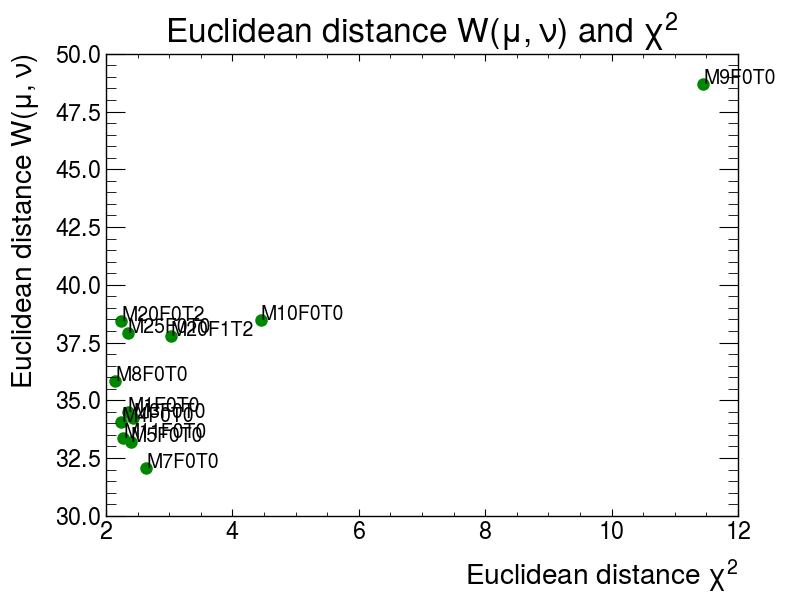

In [313]:
fig, ax = plt.subplots()
x = list(ed.values())
y = list(ed_emd.values())
labels = list(ed.keys())
ax.scatter(x, y)
for i, txt in enumerate(ed.keys()):
    ax.annotate(txt, (x[i], y[i]))

ax.set_xlabel(r'Euclidean distance $\chi^2$')
ax.set_ylabel(r'Euclidean distance $W(\mu,\nu)$')
ax.set_title(r'Euclidean distance $W(\mu,\nu)$ and $\chi^2$')

In [306]:
ed.values()[0]

TypeError: 'dict_values' object does not support indexing

# Bootstrap Errors

In [321]:
help(bs_error)

Help on function bs_error in module eda_tools.bkg_helper:

bs_error(df, kr, be, W_med, W_IQR, mu_med, mu_IQR, feature='m_hh_cor', hrange=(200, 1600))



In [322]:
help(get_norm)

Help on function get_norm in module __main__:

get_norm(df:pandas.core.frame.DataFrame, year:int=16, vr=False, weight_label:str=None) -> float



In [345]:
help(histogram_2b)

Help on function histogram_2b in module __main__:

histogram_2b(df:pandas.core.frame.DataFrame, feature:str, kinematic_region:int, norm:float, weights_column:str=None, bins:int=50, hrange:tuple=None) -> dict



In [361]:
help(shape_systematic)

Help on function shape_systematic in module __main__:

shape_systematic(df:pandas.core.frame.DataFrame, feature:str, kr:int, bins=50, hrange=None, CR_weights:str=None, VR_weights:str=None) -> dict



In [363]:
model_bs_error = {}
model_shape_error = {}
histograms_mhh_2b = {}
bs_perc_err_2b = {}
shape_perc_err_2b = {}
be = np.linspace(250, 1200, 51)
x = 0.5 * (be[:-1] + be[1:])
for model in models_keys:
    print(model)

    weight_col = w_col(16, weight_label=model)
    weight_iqr_col = w_iqr(16, weight_label=model)
    mu_med = get_norm(df, 16, weight_label=model)
    mu_IQR = get_norm_iqr(df, 16, weight_label=model)
    bs_err = bs_error(
        df,
        kr=2,
        be=be,
        W_med=weight_col,
        W_IQR=weight_iqr_col,
        mu_med=mu_med,
        mu_IQR=mu_IQR,
        feature="m_hh",
    )["h_err_bs_mag"]

    h_mhh_2b = histogram_2b(df, "m_hh", 2, mu_med, weight_col, be)

    shape_err = shape_systematic(
        df,
        "m_hh",
        2,
        be,
        CR_weights=w_col(16, weight_label=model),
        VR_weights=w_col(16, vr=True, weight_label=model),
    )['shape_err']

    model_bs_error[model] = np.abs(bs_err)
    model_shape_error[model] = shape_err
    histograms_mhh_2b[model] = h_mhh_2b["h_2b"]
    bs_perc_err_2b[model] = 100 * np.abs(bs_err) / h_mhh_2b["h_2b"]
    shape_perc_err_2b[model] = 100 * shape_err / h_mhh_2b['h_2b']

M1F0T0
M3F0T0
M4F0T0
M5F0T0
M7F0T0
M8F0T0
M9F0T0
M10F0T0
M11F0T0
M20F0T2
M20F1T2
M25F0T0


In [365]:
for key in model_bs_error.keys():
    plt.plot(x, np.abs(model_bs_error[key]), label = key)
plt.legend()
plt.xlabel(r'$m_{HH}$')
plt.ylabel('Absolute Bootsrap error')
_=plt.title('Bootstrap Error comparison')

In [358]:
for i in range(20):
    print(i%5)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


In [367]:
NUM_COLORS = 5
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)
clrs = sns.color_palette('husl', n_colors=NUM_COLORS)

for i, key in enumerate(model_bs_error.keys()):
    l = plt.plot(x, np.abs(bs_perc_err_2b[key]), label = key)
    l[0].set_color(clrs[i%NUM_COLORS])
    l[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])
plt.legend(bbox_to_anchor=(1.30, 1), loc='upper right')
plt.xlabel(r'$m_{HH}$')
plt.ylabel('Percentage Bootsrap error [%]')
_=plt.title('Bootstrap Error comparison')

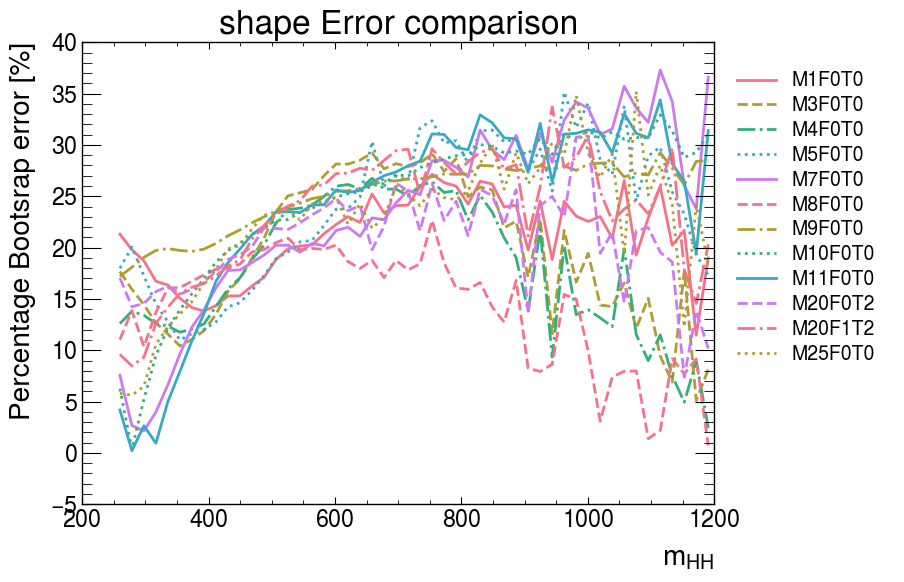

In [368]:
NUM_COLORS = 5
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)
clrs = sns.color_palette('husl', n_colors=NUM_COLORS)

for i, key in enumerate(model_bs_error.keys()):
    l = plt.plot(x, np.abs(shape_perc_err_2b[key]), label = key)
    l[0].set_color(clrs[i%NUM_COLORS])
    l[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])
plt.legend(bbox_to_anchor=(1.30, 1), loc='upper right')
plt.xlabel(r'$m_{HH}$')
plt.ylabel('Percentage Bootsrap error [%]')
_=plt.title('shape Error comparison')

# DEBUG

**what is the perfect wasserstein distance?**

In [252]:
mu = np.random.normal(0, 1, 1000000)
nu = np.random.normal(1, 1, 1000000)

In [253]:
h_mu,be = np.histogram(mu, bins = 50,density=True)
h_nu, _ = np.histogram(nu, bins=be, density=True)

In [254]:
wasserstein_distance(mu,nu)

0.9994550275729673

In [255]:
wasserstein_distance(h_mu, h_nu)

0.0026868106626457074

In [247]:
e

NameError: name 'e' is not defined

**Some error building dicts**

In [284]:
mydict= {}

In [285]:
numbers= [1, 2, 3, 4]

In [286]:
mydict['key'] = numbers

In [287]:
mydict

{'key': [1, 2, 3, 4]}